## [Title goes here]
### IITGN CS612 Fall 2017 - Project Checkpoint Presentation (13 November 2017)
### Sohhom Bandyopadhyay (15510011) and Sujata Sinha (15350008)

**Based on trace files from: ** <br>
http://iotta.snia.org/tracetypes/3 (Nexus 5 Smartphone Traces) <br>
Zhou, D., Pan, W., Wang, W., & Xie, T. (2015, October). I/O characteristics of smartphone applications and their implications for eMMC design. In Workload Characterization (IISWC), 2015 IEEE International Symposium on (pp. 12-21). IEEE.



** Outline (this notebook):**
 - Description of trace file format
 - Extraction of timestamps from log files
 - Calculating correlation between request size and duration (e.g. turnaround time and hardware processing time)
 - plots of:
    - plot1
    - plot2
 - some more thing
 

** ToDo (next two weeks): ** <br>
 -  Machine learning classifier to predict the block access

## Trace file format:
**column 0** : start address (in sectors) <br>
**column 1** : access size (in sectors) <br>
**column 2** : access size (in byte) <br>
**column 3** : access type & waiting status (3 bit number):
 - LSB: indicates read (0) or write (1)
 - MSB: indicates waiting status (0 = yes, 1 = no)
 - Middle bit: unused <br>
 (It's not represented as binary, but as integers : 0, 1, 4 and 5 )
 <br>
 
**column 4** : request generate time (generated and inserted into request queue). <br>
**column 5** : request process start time (fetched and and began processing)  <br>
**column 6** : request submit time (submitted to hardware) <br>
**column 7** : request finish time (completed, callback function invoked)  <br>

Thus, any request goes through 4 stages: push to queue -> start processing -> submit to hardware -> finish (callback)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn
%matplotlib notebook

In [2]:
data_dir = 'Trace_files'
fnames = [x for x in filter(lambda x: x.endswith('.txt'), os.listdir(os.path.join('.', data_dir)))]
workload_names = [ x for x in map(lambda x: x.split('_')[1].split('.')[0], fnames) ]

In [3]:
# a dict of dataframes, tread (index) lightly..
dataset = {fname.split('_')[1].split('.')[0]:pd.read_csv(os.path.join(data_dir, fname), delimiter='\s+', header = None, dtype = float) for fname in fnames for fname in fnames}

## convert unix timestamps to datetime objects
also, extract the request size

In [4]:
request_sizes = { workname:dataset[workname].iloc[:,2] for workname in workload_names }
for cindx in 4, 5, 6, 7:
    for df in dataset.values():
        df.loc[:,cindx] = df.loc[:,cindx].apply(datetime.fromtimestamp)

### Calculate durations
 ... of various processing stages

In [5]:
turnaround_time = {}
hw_time = {}
for name in workload_names:
    turnaround_time[name] = dataset[name].iloc[:,7] - dataset[name].iloc[:,4]
    turnaround_time[name] = turnaround_time[name].apply(lambda x: x.components.milliseconds*1000+x.components.microseconds)
    hw_time[name] = dataset[name].iloc[:,7] - dataset[name].iloc[:,6]
    hw_time[name] = hw_time[name].apply(lambda x: x.components.milliseconds*1000+x.components.microseconds)

### Plot averages across activities

In [6]:
avg_req_size       = {x:np.mean(request_sizes[x]) for x in workload_names}
avg_req_size_stdev = {x:np.std(request_sizes[x]) for x in workload_names}

<IPython.core.display.Javascript object>


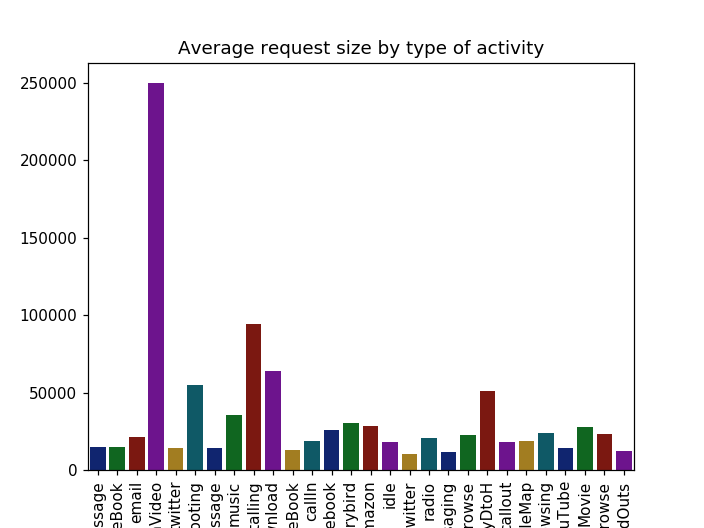

In [11]:
somevar = seaborn.barplot(list(avg_req_size.keys()), list(avg_req_size.values()), palette='dark')
for item in somevar.get_xticklabels():
    item.set_rotation(90)
plt.title("Average request size by type of activity")
plt.show()

In [8]:
avg_tat       = {x:np.mean(turnaround_time[x]) for x in workload_names}

<IPython.core.display.Javascript object>


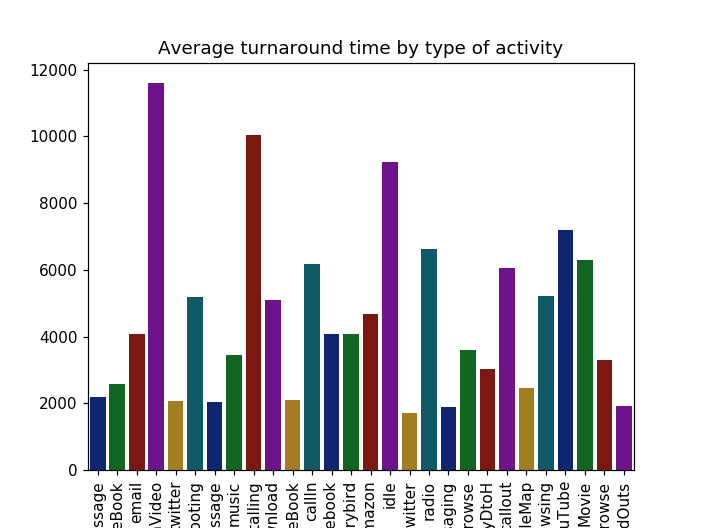

In [10]:
somevar = seaborn.barplot(list(avg_tat.keys()), list(avg_tat.values()), palette='dark')
for item in somevar.get_xticklabels():
    item.set_rotation(90)
plt.title("Average turnaround time by type of activity")
plt.show()